In [42]:
import deep_predictor
from collections.abc import Mapping
import torch
import scanpy as sc

In [43]:
import scipy.stats as ss
import numpy as np
import scipy.stats as ss
sc.set_figure_params(dpi=250, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
import pandas as pd

In [44]:
import numpy as np
import pandas as pd

In [45]:
training_data = sc.read("/home/gaurav/Gaurav/Berlin/Paper/Pijuan_sala_data/Ectoderm_lineage_ds.h5ad")
training_data.obs["cells"] = "Training data"

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [46]:
training_data.obs["data"] = (training_data.obs["Time"] == 8.5).astype('uint8') 

In [47]:
testing_data = sc.read("/home/gaurav/Gaurav/Berlin/Paper/Pijuan_sala_data/Mesoderm_lineage_ds.h5ad")
testing_data.obs["data"] = (testing_data.obs["Time"] == 8.5).astype('uint8') 

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
zebra_obj = deep_predictor.DeepPredictor(training_data,latent_dim=100,hidden_layers=[800,800],workers=8,parameters=[0,0,1,0,1],likelihood="nb",batch_size=100)

In [49]:
zebra_obj.reload_model(path="/home/gaurav/Gaurav/Berlin/Paper/Pijuan_sala_data/Models/Ectoderm_trained_ds.pt") # NB + MMD

In [50]:
zebra_obj.runFlows(0,1,"data")

In [51]:
zebra_obj.trainFlows(iterations=100)

Loss (it. 0) : 23.027680
Loss (it. 10) : 22.612310
Loss (it. 20) : 21.698589
Loss (it. 30) : 20.146472
Loss (it. 40) : 18.074284
Loss (it. 50) : 15.747417
Loss (it. 60) : 13.490701
Loss (it. 70) : 11.324384
Loss (it. 80) : 9.458191
Loss (it. 90) : 7.764004


In [52]:
Real_data = testing_data[testing_data.obs["data"] == 1]
Real_data.obs["cells"] = "Real data"
Test_data = testing_data[testing_data.obs["data"] == 0]
Test_data.obs["cells"] = "Test data"

/tmp/ipykernel_1552/3089014902.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Real_data.obs["cells"] = "Real data"
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_1552/3089014902.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Test_data.obs["cells"] = "Test data"


In [53]:
adata_test = Real_data.concatenate(Test_data)

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [54]:
adata_mouse_mesoderm_forward,px_scale,theta,px_rate = zebra_obj.predict(adata_test,0,1,"data")


/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pca_pal = ["#d62728","#ff7f0e","#1f77b4"]


def corrfunc(x, y, **kws):
	slope, intercept, r, p_value, _err = stats.linregress(x, y)
	ax = plt.gca()
	ax.annotate("$R^2$ = {:.2f}".format(r**2),
				xy=(.1, .9), xycoords=ax.transAxes)


def Plotting_Correlation_genes(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.average(real_data.X,axis = 0),np.average(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    major_ticks = np.arange(0, 350,100)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    #plt.xlim(0,80) 
    #plt.ylim(0,80)
    plt.grid(False)
    sns.despine(offset=5)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)   
    plt.show()
    
def Plotting_Correlation_var(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.std(real_data.X,axis = 0),np.std(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    major_ticks = np.arange(0, 200,50)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    sns.despine(offset=2)
    #plt.xlim(-1,25) 
    #plt.ylim(-1,25)
    plt.grid(False)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)
    plt.show()
    
def Plotting_Correlation_var_log(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.std(real_data.X,axis = 0),np.std(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    major_ticks = np.arange(0,1,0.2)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    plt.xlim(-0.1,1) 
    plt.ylim(-0.1,1)
    plt.grid(False)
    sns.despine(offset=5)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)   
    plt.show() 
    
def Plotting_Correlation_genes_log(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.average(real_data.X,axis = 0),np.average(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    major_ticks = np.arange(0,5,2)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    plt.xlim(0,5) 
    plt.ylim(0,5)
    plt.grid(False)
    sns.despine(offset=5)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)   
    plt.show()    

In [75]:
pca_pal = ["#d62728","#ff7f0e","#1f77b4"]

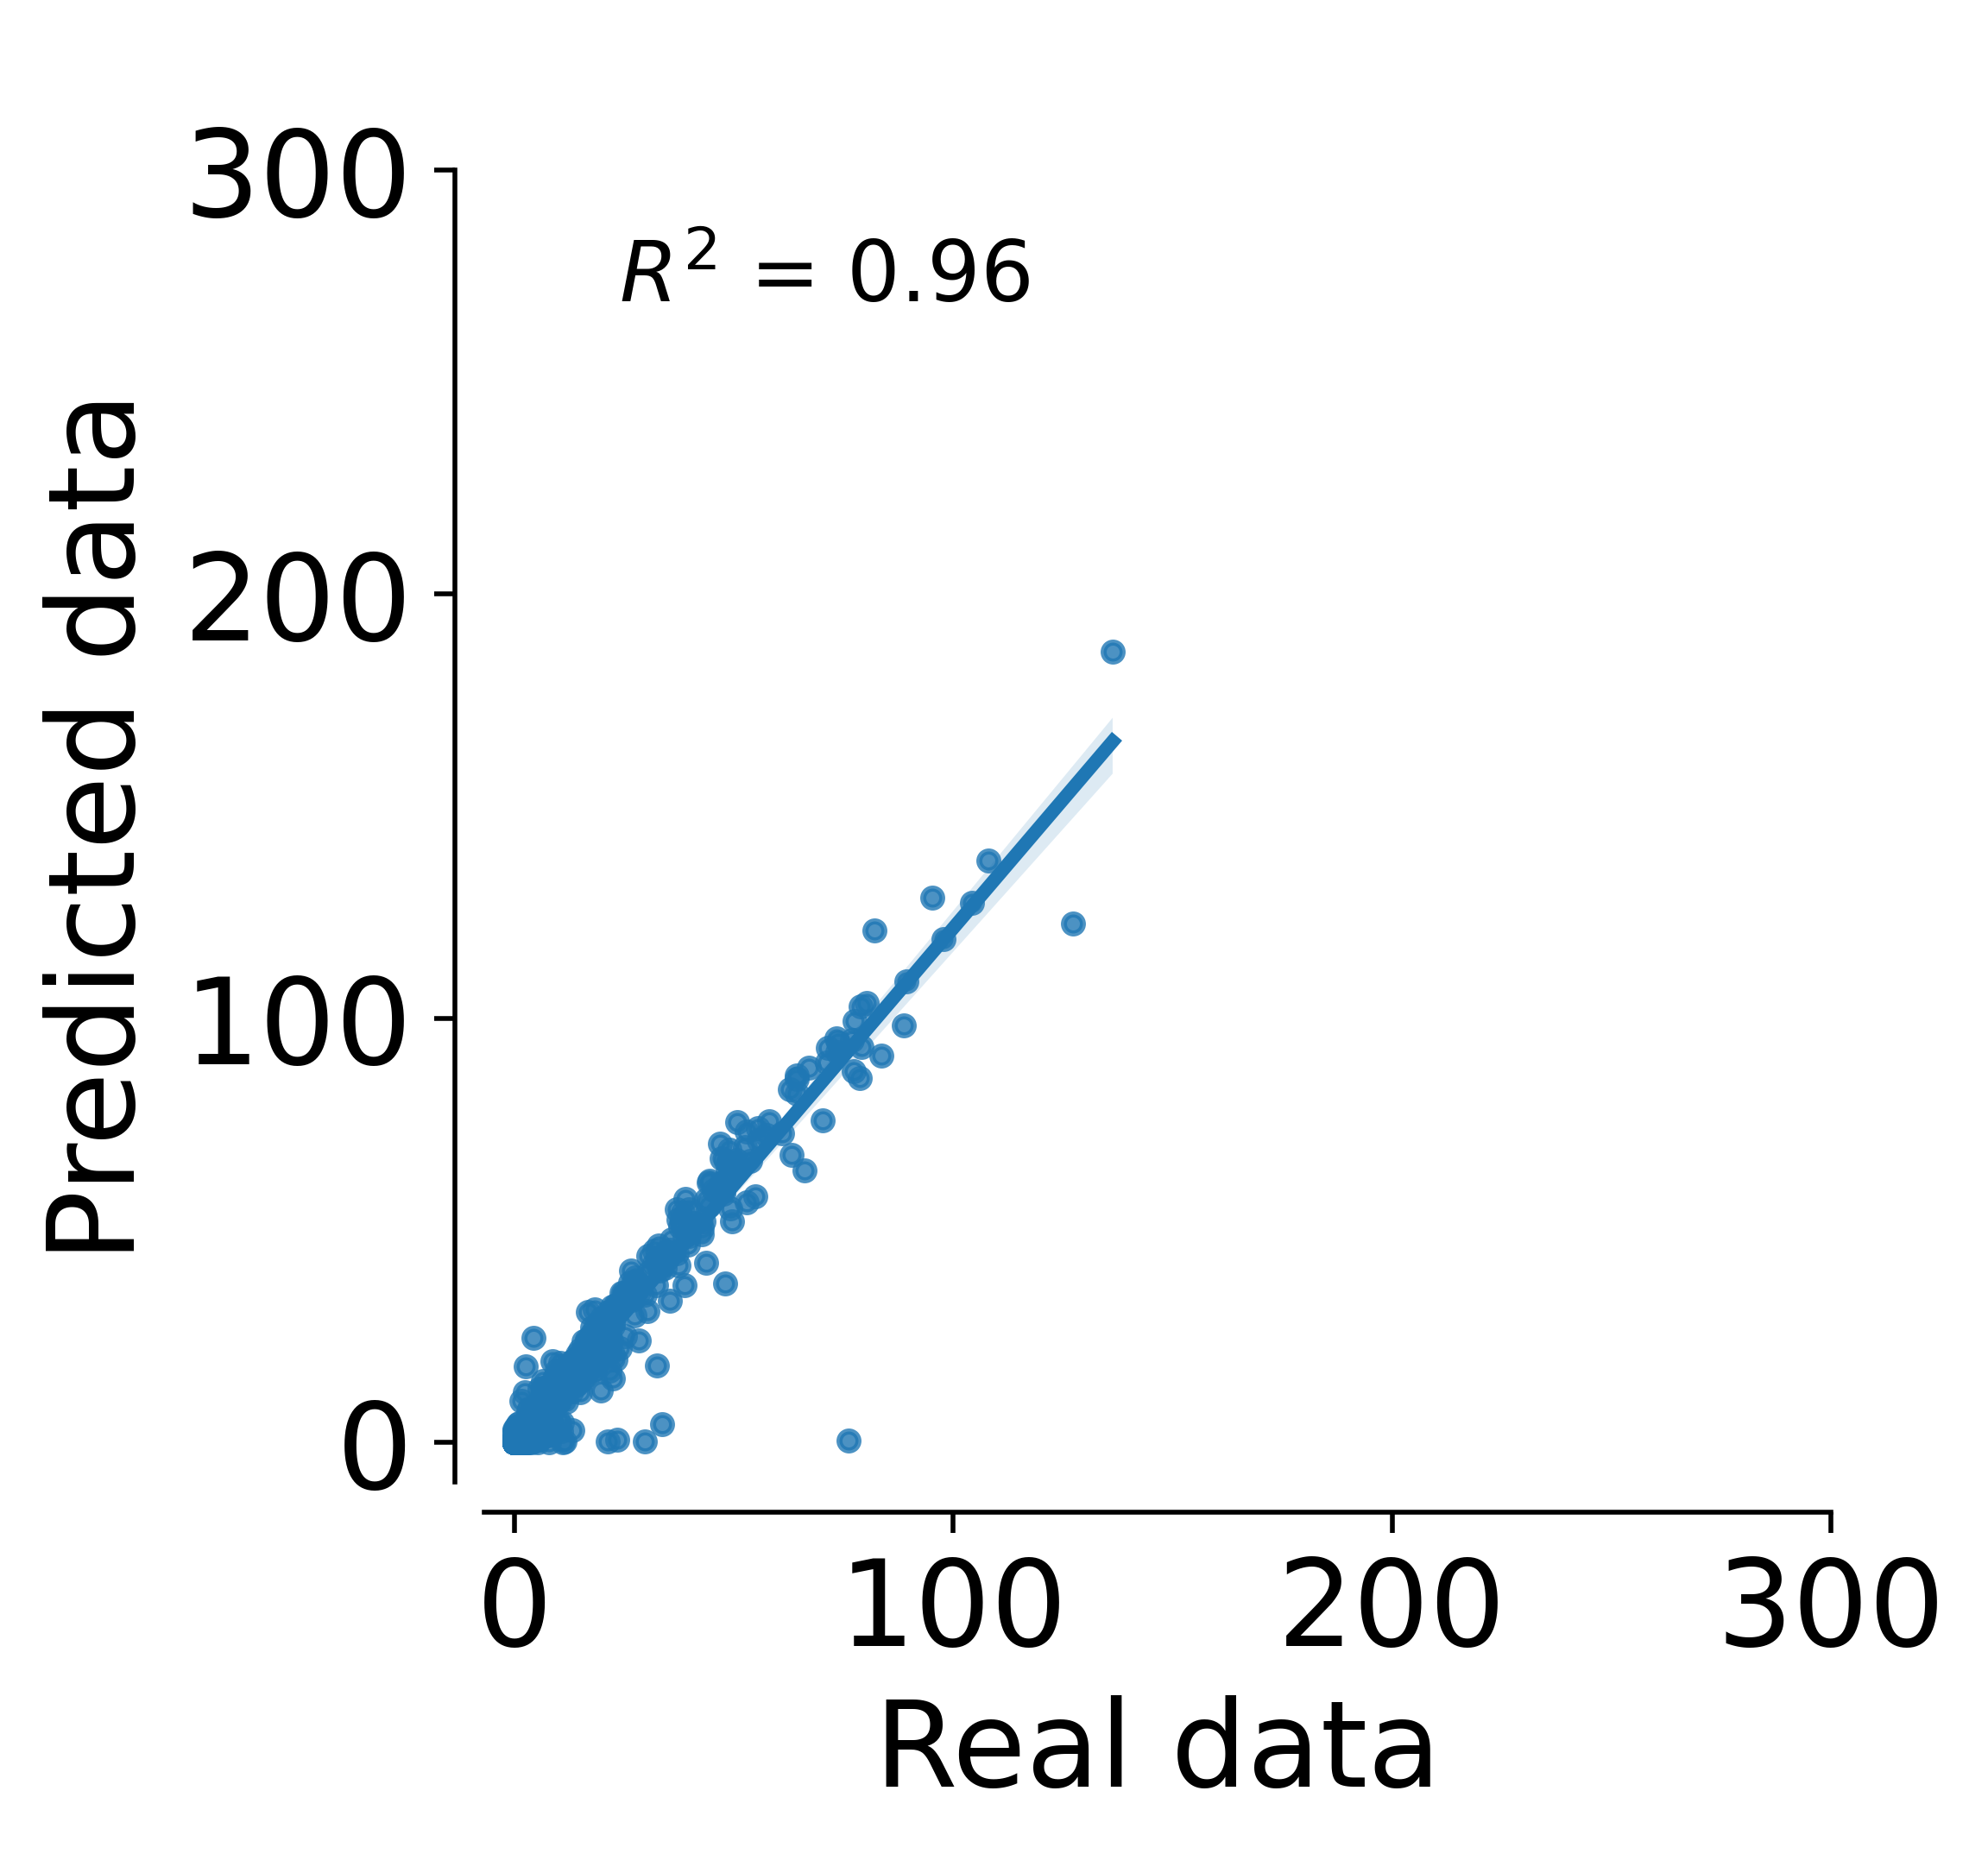

In [76]:
Plotting_Correlation_genes(adata_mouse_mesoderm_forward," ",pca_pal[2])


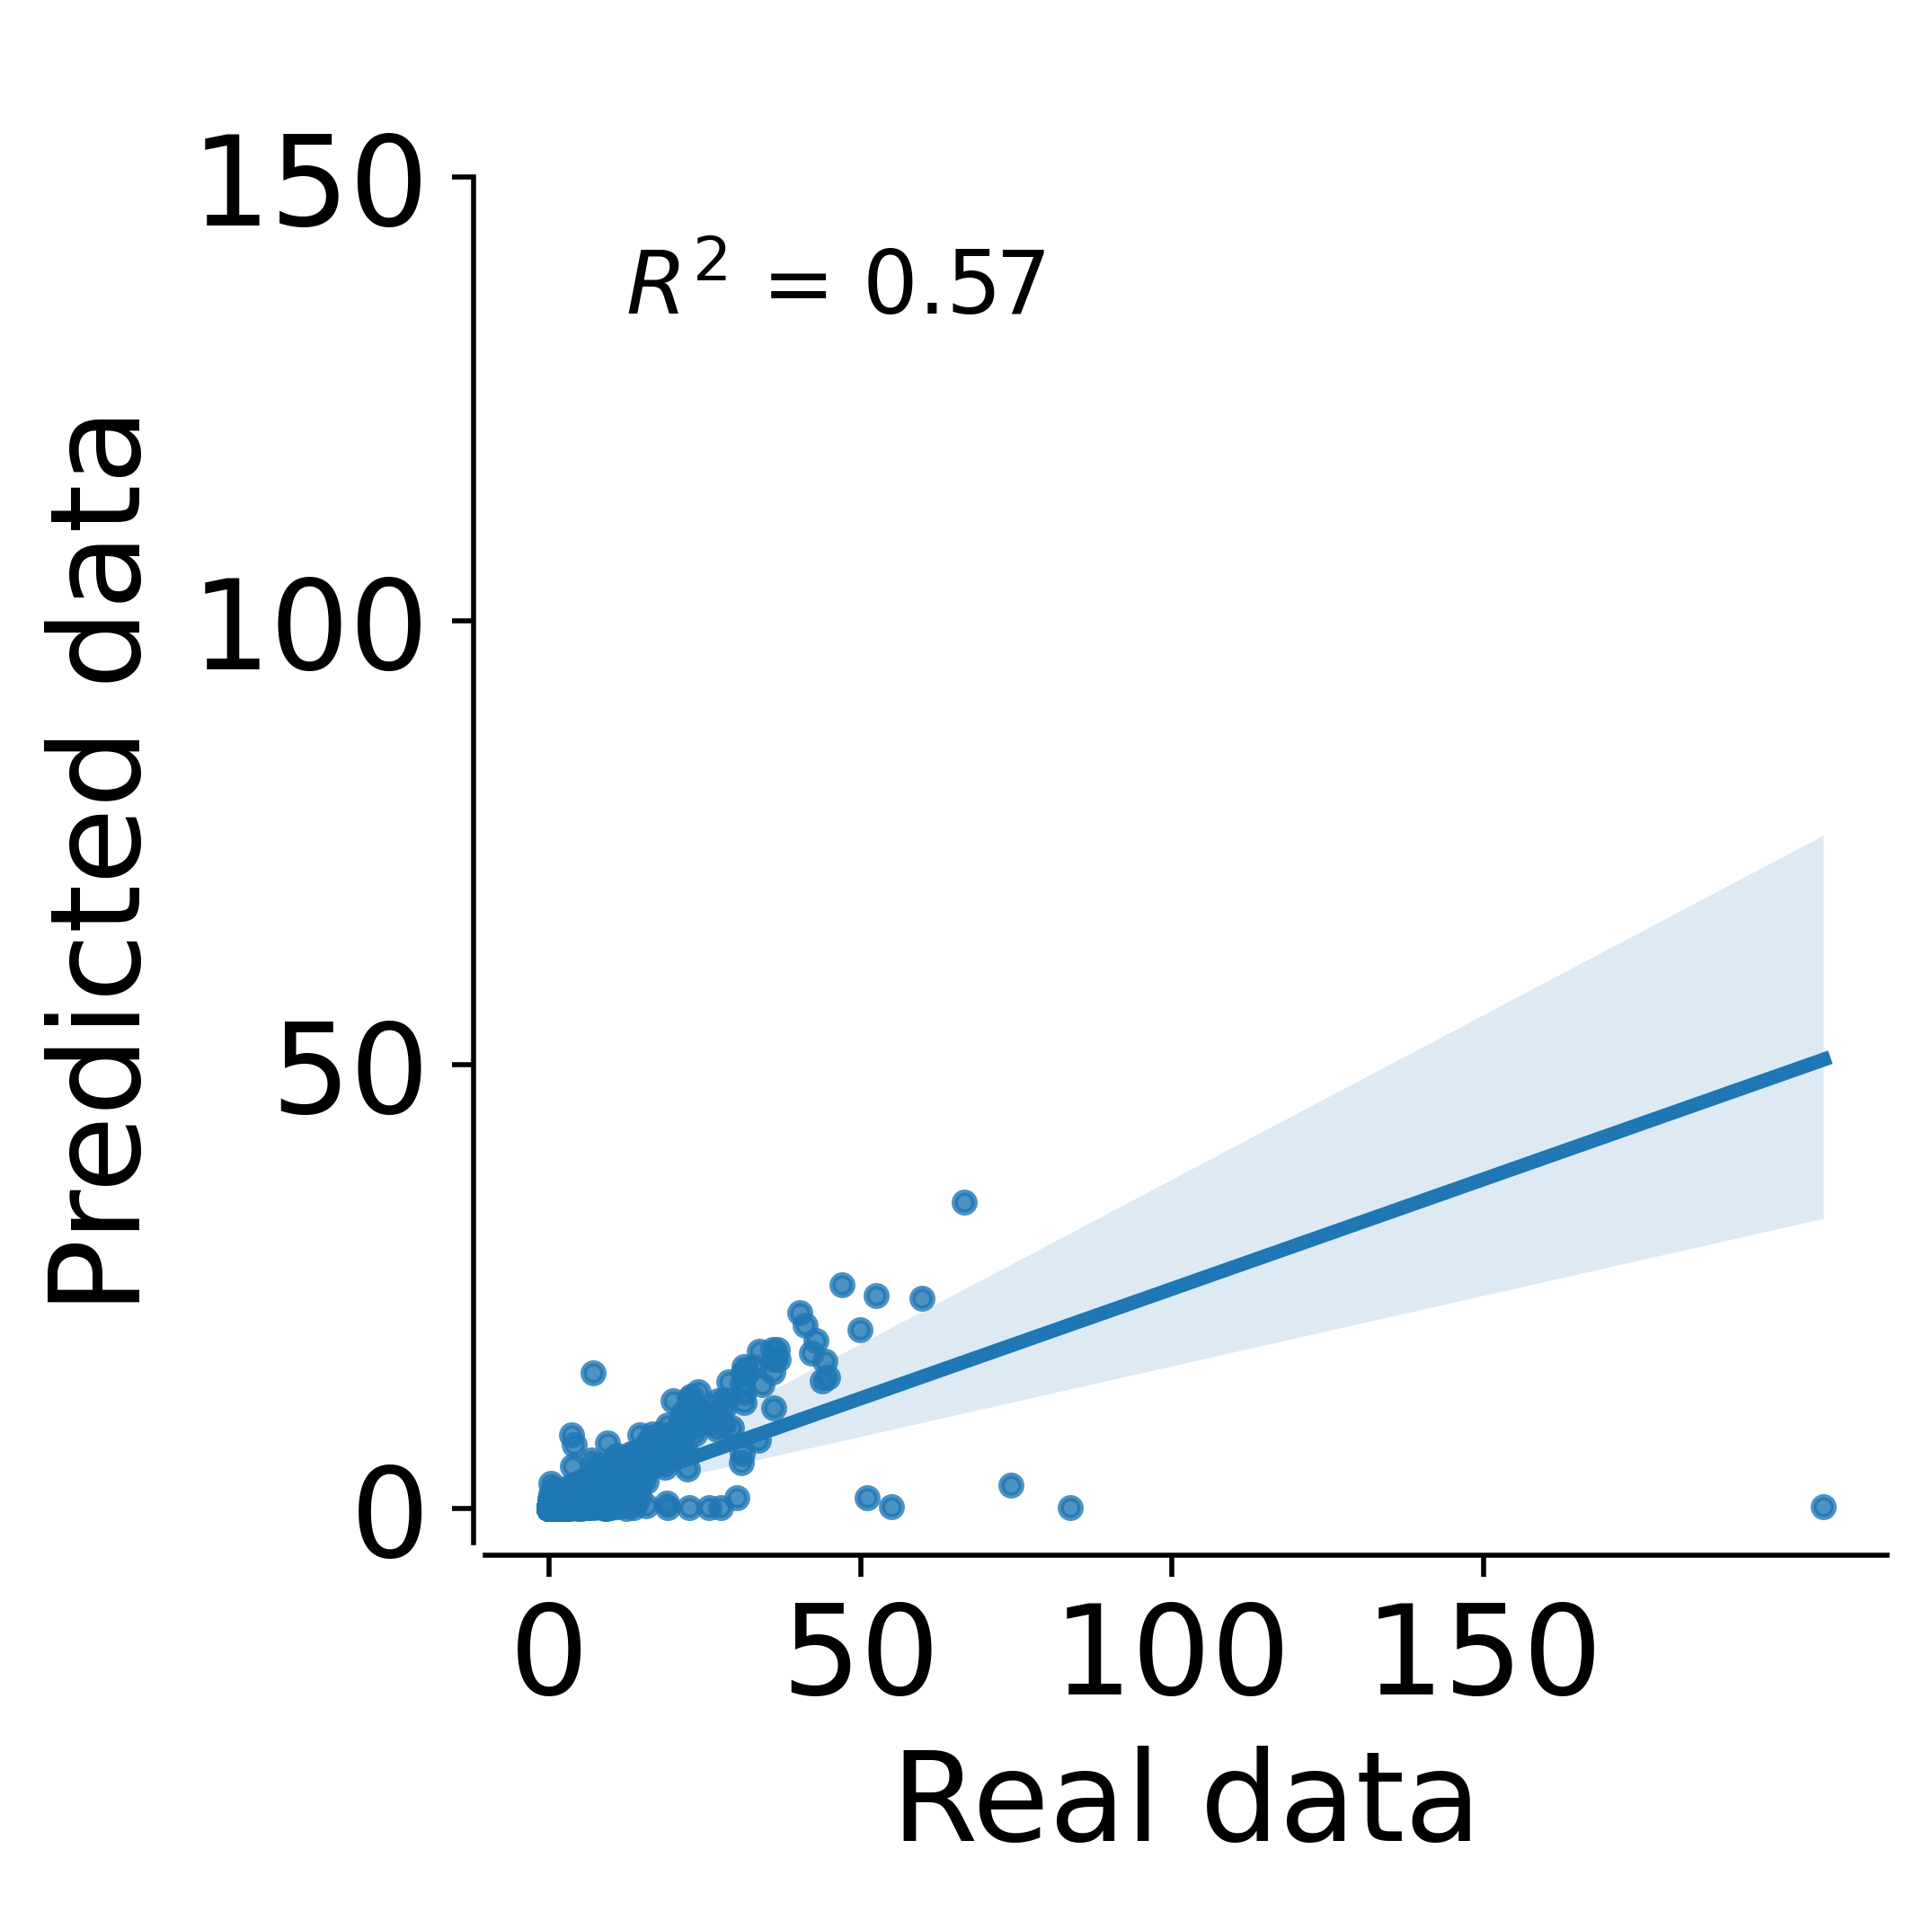

In [77]:
Plotting_Correlation_var(adata_mouse_mesoderm_forward," ",pca_pal[2])


In [85]:
adata_mouse_mesoderm_forward.write_h5ad("/home/gaurav/Gaurav/Berlin/Paper/Pijuan_sala_data/Objects/mesoderm_forward_.h5ad")

In [84]:
adata_mouse_mesoderm_forward.obs["doublet"] = 0
adata_mouse_mesoderm_forward.obs["stripped"] = 0